This bit of code is needed to install a web-driver that is used in the web-scraping process, as I used the Selenium library for this project which requires a proper web browser driver.

In [1]:
if 'google.colab' in str(get_ipython()):
    print('Google CoLab Installation')
    !apt update --quiet
    !apt install chromium-chromedriver --quiet

Google CoLab Installation
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,004 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,081 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,269 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,343 kB]
Hit:13 http

Install the selenium Library.

In [2]:
!pip install selenium --quiet
print("Selenium installed succesfully")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.5 MB/s eta 0:00:00
Selenium installed succesfully


Import all the required modules/libraries necesary for web-scraping.

In [3]:
print('Library Import')
if 'google.colab' not in str(get_ipython()):
    print('Not running on CoLab')
    from selenium.webdriver.chrome.options import Options
    from selenium.webdriver.chrome.service import Service
    import os
else:
    print('Running on CoLab')

print('Common Library Import')
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time

Library Import
Running on CoLab
Common Library Import


Create an instance of a Chrome WebDriver, which is used to navigate to the designated webpage that needs to be scraped.

In [4]:
def get_driver(url):
    """Return web driver"""
    colab_options = webdriver.ChromeOptions()
    colab_options.add_argument('--no-sandbox')
    colab_options.add_argument('--disable-dev-shm-usage')
    colab_options.add_argument('--headless')
    colab_options.add_argument('--start-maximized')
    colab_options.add_argument('--start-fullscreen')
    colab_options.add_argument('--single-process')
    driver = webdriver.Chrome(options=colab_options)
    driver.get(url)
    return driver

Sanity check: test run of the get_driver method coded above, to see if it navigates to the webpage correctly. We check this by asking it to print the title of the website.

In [5]:
driver = get_driver('https://finance.yahoo.com/cryptocurrencies')
print(driver.title)

Crypto Real Time Prices & Latest News - Yahoo Finance


Check if the find_elements method works; we check this by printing the name 2 of the columns in the dataset

In [6]:
header = driver.find_elements(By.TAG_NAME, value= 'th')
print(header[0].text)
print(header[2].text)

Symbol
Price (Intraday)


These methods are all helper methods for the actual webscraping process:

- The get_table_header method is used to get the first 10 columns from the header, using List comprehension with conditions. It returns the names of each column in a list format.
- The get_table_rows method is used to find the number of rows in the dataset on the webpage.
- The parse_table_rows method is for parsing(scraping) the data one row at a time; it returns the column value in the form of a dictionary.
- The parse_multiple_pages is used to parse multiple pages of the same dataset; for the sake of this project, I stuck to one page.

In [7]:
def get_table_header(driver):
    """Return Table columns in list form """
    header = driver.find_elements(By.TAG_NAME, value= 'th')
    header_list = [item.text for index, item in enumerate(header) if index < 10]
    return header_list

txt=driver.find_element(By.XPATH, value='//*[@id="scr-res-table"]/div[1]/table/tbody/tr[1]').text
txt

def get_table_rows(driver):
    """Get number of rows available on the page """
    tablerows = len(driver.find_elements(By.XPATH, value='//*[@id="scr-res-table"]/div[1]/table/tbody/tr'))
    return tablerows

driver.find_element(By.XPATH, value='//*[@id="scr-res-table"]/div[1]/table/tbody/tr[1]/td[2]').text

def parse_table_rows(rownum, driver, header_list):
    """get the data for one row at a time and return column value in the form of dictionary"""
    row_dictionary = {}
    #time.sleep(1/3)
    for index , item in enumerate(header_list):
        time.sleep(1/20)
        column_xpath = '//*[@id="scr-res-table"]/div[1]/table/tbody/tr[{}]/td[{}]'.format(rownum, index+1)
        row_dictionary[item] = driver.find_element(By.XPATH, value=column_xpath).text
    return row_dictionary

button_element = driver.find_element(By.XPATH, value = '//*[@id="scr-res-table"]/div[2]/button[3]')
button_element.click()

def parse_multiple_pages(driver, total_crypto):
    """Loop through each row, perform Next button click at the end of page
    return total_crypto numbers of rows
    """
    table_data = []
    page_num = 1
    is_scraping = True
    header_list = get_table_header(driver)

    while is_scraping:
        table_rows = get_table_rows(driver)
        print('Found {} rows on Page : {}'.format(table_rows, page_num))
        print('Parsing Page : {}'.format(page_num))
        table_data += [parse_table_rows(i, driver, header_list) for i in range (1, table_rows + 1)]
        total_count = len(table_data)
        print('Total rows scraped : {}'.format(total_count))
        if total_count >= total_crypto:
            print('Done Parsing..')
            is_scraping = False
        else:
            print('Clicking Next Button')
            element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.XPATH, '//*[@id="scr-res-table"]/div[2]/button[3]')))
            element.click()
            page_num += 1
    return table_data



This method is used to actually perform the web-scraping using the helper methods defined above and saves the data to a csv file.

In [8]:
def scrape_yahoo_crypto(url, total_crypto, path=None):
    """Get the list of yahoo finance crypto-currencies and write them to CSV file """
    if path is None:
        path = 'crypto-currencies.csv'
    print('Creating driver')
    driver = get_driver(url)
    table_data = parse_multiple_pages(driver, total_crypto)
    driver.close()
    driver.quit()
    print('Save the data to a CSV')
    table_df = pd.DataFrame(table_data)
    table_df.to_csv(path, index=None)
    #This return statement is optional, we are doing this just analyze the final output
    return table_df


Scrapes the data and creates a local dataframe that can be used for analysis. Also a sanity check; prints the first 5 rows of the dataset.

In [10]:
YAHOO_FINANCE_URL = 'https://finance.yahoo.com/cryptocurrencies'
TOTAL_CRYPTO = 25
crypto_df = scrape_yahoo_crypto(YAHOO_FINANCE_URL, TOTAL_CRYPTO,'crypto-currencies.csv')
crypto_df.head()

Creating driver
Found 25 rows on Page : 1
Parsing Page : 1
Total rows scraped : 25
Done Parsing..
Save the data to a CSV


,Symbol,Name,Price (Intraday),Change,% Change,Market Cap,Volume in Currency (Since 0:00 UTC),Volume in Currency (24Hr),Total Volume All Currencies (24Hr),Circulating Supply
0,BTC-USD,Bitcoin USD,"27,383.44",-215.01,-0.78%,534.256B,9.821B,9.821B,9.821B,19.51M
1,ETH-USD,Ethereum USD,"1,570.03",-9.58,-0.61%,188.8B,5.175B,5.175B,5.175B,120.252M
2,USDT-USD,Tether USDt USD,1.0004,+0.0002,+0.02%,83.529B,17.156B,17.156B,17.156B,83.495B
3,BNB-USD,BNB USD,206.78,+0.46,+0.22%,31.812B,441.578M,441.578M,441.578M,153.845M
4,XRP-USD,XRP USD,0.496389,-0.003761,-0.75%,26.501B,647.947M,647.947M,647.947M,53.387B


Descrptive statistics for the "Change" column.

In [30]:
column_names = crypto_df.columns
print (column_names)

average_change = crypto_df["Change"]
average_change = average_change.astype(float)
print (average_change)

Index(['Symbol', 'Name', 'Price (Intraday)', 'Change', '% Change',
       'Market Cap', 'Volume in Currency (Since 0:00 UTC)',
       'Volume in Currency (24Hr)', 'Total Volume All Currencies (24Hr)',
       'Circulating Supply'],
      dtype='object')
0    -215.010000
1      -9.580000
2       0.000200
3       0.460000
4      -0.003761
5       0.000400
6      -8.710000
7       0.180000
8       0.001367
9      -0.001798
10      0.000470
11      0.000128
12      0.027100
13     -0.000079
14     -0.009481
15     -0.030200
16      0.040000
17   -178.950000
18     -5.670000
19     -0.000000
20     -0.022800
21      0.048600
22      0.000642
23     -0.032800
24      0.026500
Name: Change, dtype: float64


In [28]:
average_change.describe()

count     25.000000
mean     -16.689420
std       54.577554
min     -215.010000
25%       -0.030200
50%        0.000000
75%        0.001367
max        0.460000
Name: Change, dtype: float64

Plots a bar graph for the first 6 cryptos in the dataframe, and the change in their price today (October 10th).

Text(0.5, 1.0, 'Change in price for 5 cryptos')

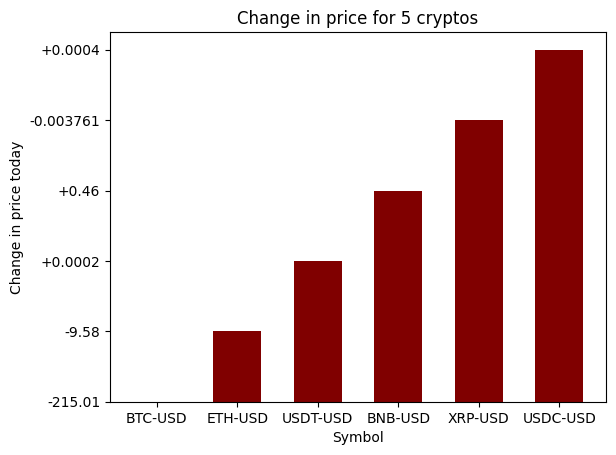

In [44]:
from matplotlib import pyplot as plt

symbol_column = crypto_df["Symbol"]
change_column = crypto_df["Change"]

selected_symbols = []
selected_change = []

for i in range(6):
    selected_symbols.append(symbol_column[i])
    selected_change.append(change_column[i])


# Now plot our bar graph
plt.bar(selected_symbols, selected_change, color ='maroon', width = 0.6)

# Now add axis labels with units
plt.xlabel("Symbol")
plt.ylabel("Change in price today")

# We can add a title too
plt.title("Change in price for 5 cryptos")